# Rplan validation

## Source

In [8]:
def check_rooms(rooms):
    valid = True
    if rooms == None:
        valid = False
    else:
        for room in rooms:
            mask = room["mask"]
            contours = mask_to_contour(mask, concat=False)
            if len(contours) != 1:
                valid = False
                break
    return valid

def get_room_type(img_room_types, room_mask):
    # return room type in the specified area ignoring doors
    type_mask_inds = np.where((room_mask == 1) & (img_room_types != 15) & (img_room_types != 17))
    room_type = list(set(img_room_types[type_mask_inds].flatten().tolist()))[0]
    return room_type

def get_room_mask(img_room_inds, ind):
    # return room mask of ones
    room_mask = np.where(img_room_inds==ind, np.ones_like(img_room_inds), np.zeros_like(img_room_inds)).astype(np.uint8)
    return room_mask


def mask_to_contour(mask, concat=True):
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    contours = [contour.squeeze(1) for contour in contours]
    if len(contours) == 0:
        return None
    if concat:
        contours = np.concatenate(contours).T
        # opencv coordinates to numpy indexes
        contours[[0, 1]] = contours[[1, 0]]
    else:
        transformed_contours = []
        for c in contours:
            c = c.T
            c[[0, 1]] = c[[1, 0]]
            transformed_contours.append(c)
        contours = transformed_contours
    return contours

def mask_to_corners(mask):
    contours, _ = cv.findContours(mask.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = [contour.squeeze(1) for contour in contours]
    if len(contours) == 0:
        return None
    contours = np.concatenate(contours).T
    # opencv coordinates to numpy indexes
    contours[[0, 1]] = contours[[1, 0]]
    return contours

def mask_to_vertices(mask):
    corner_points = mask_to_corners(mask)
    if "NoneType" in str(type(corner_points)):
        return None
    corner_pairs = []
    in_pairs = []
    removes = np.ones(corner_points.shape[1])
    for i in range(corner_points.shape[1]):
        for j in range(i + 1, corner_points.shape[1]):
            point1 = corner_points[:,i]
            point2 = corner_points[:,j]
            if abs(point1[0]-point2[0]) == 1 and abs(point1[1]-point2[1]) == 1:

                sorted_points = [point1, point2] if point1[1] < point2[1] else [point2, point1]
                sorted_inds = [i, j] if point1[1] < point2[1] else [j, i]
                local_point1, local_point2 = sorted_points
                ind1, ind2 = sorted_inds
                if sorted_points[0][0] < sorted_points[1][0]:
                    if mask[local_point1[0] + 1, local_point1[1]] == 0:
                        if mask[local_point1[0], local_point1[1] - 1] == 0:
                            removes[ind1] = 0
                        if mask[local_point2[0] + 1, local_point2[1]] == 0:
                            removes[ind2] = 0
                    else:
                        if mask[local_point2[0], local_point2[1] + 1] == 0:
                            removes[ind2] = 0
                        if mask[local_point1[0] - 1, local_point1[1]] == 0:
                            removes[ind1] = 0
                else:
                    if mask[local_point1[0] - 1, local_point1[1]] == 0:
                        if mask[local_point1[0], local_point1[1] - 1] == 0:
                            removes[ind1] = 0
                        if mask[local_point2[0] - 1, local_point2[1]] == 0:
                            removes[ind2] = 0
                    else:
                        if mask[local_point2[0], local_point2[1] + 1] == 0:
                            removes[ind2] = 0
                        if mask[local_point1[0] + 1, local_point1[1]] == 0:
                            removes[ind1] = 0

                corner_pairs.append([point1, point2])
                in_pairs.append(i)
                in_pairs.append(j)
    base_corners = []
    for i in range(corner_points.shape[1]):
        point = corner_points[:,i]
        if i not in in_pairs or removes[i] == 0:
            base_corners.append(np.expand_dims(point, axis=1))
    base_corners = np.concatenate(base_corners, axis=1)
    if len(corner_pairs) == 0:
        return corner_points

    merged_corners = []
    for pair in corner_pairs:
        point1 = pair[0]
        point2 = pair[1]
        min_a = min(point1[0], point2[0])
        max_a = max(point1[0], point2[0])
        min_b = min(point1[1], point2[1])
        max_b = max(point1[1], point2[1])
        candidates = None
        if point1[0] == min_a and point1[1] == min_b or point1[0] == max_a and point1[1] == max_b:
            candidates = [np.array([min_a, max_b]), np.array([max_a, min_b])]
        elif point1[0] == min_a and point1[1] == max_b or point1[0] == max_a and point1[1] == min_b:
            candidates = [np.array([min_a, min_b]), np.array([max_a, max_b])]
        else:
            return None
        merged_point = None
        if mask[candidates[0][0], candidates[0][1]] == 1:
            merged_point = candidates[0]
        elif mask[candidates[1][0], candidates[1][1]] == 1:
            merged_point = candidates[1]
        else:
            return None
        merged_point = np.expand_dims(merged_point, axis=1)
        merged_corners.append(merged_point)
    merged_corners = np.concatenate(merged_corners, axis=1)
    vertices = np.concatenate([base_corners, merged_corners], axis=1)
    return vertices

def mask_to_lines(mask, vertices=False):
    contour_points = mask_to_contour(mask)
    corner_points = mask_to_vertices(mask) if vertices else mask_to_corners(mask)
    if "NoneType" in str(type(contour_points)) or "NoneType" in str(type(corner_points)):
        return None
    lines = []
    contour_points = contour_points.T
    corner_points = corner_points.T
    for i in range(len(corner_points)):
        for j in range(i + 1, len(corner_points)):
            left_point = corner_points[i]
            right_point = corner_points[j]
            # check if corners can be bounds of vertical or horizontal line because they have equal coordinate
            if not (left_point[0] == right_point[0] or left_point[1] == right_point[1]):
                continue

            equal_ind = 0 if left_point[0] == right_point[0] else 1
            boundary_ind = 0 if equal_ind == 1 else 1
            min_boundary = left_point[boundary_ind] if left_point[boundary_ind] < right_point[boundary_ind] else right_point[boundary_ind]
            max_boundary = left_point[boundary_ind] if left_point[boundary_ind] > right_point[boundary_ind] else right_point[boundary_ind]

            # find contour points between corner points
            eval_inds = np.where((contour_points[:,equal_ind] == left_point[equal_ind]) & (contour_points[:,boundary_ind] >= min_boundary) & (contour_points[:,boundary_ind] <= max_boundary))
            # if there are no contour points between two corner points that means that this points are not bounds of contour line
            if len(eval_inds[0]) < max_boundary - min_boundary - 1:
                continue

            line_inds = np.where((contour_points[:,equal_ind] == left_point[equal_ind]) & (contour_points[:,boundary_ind] > min_boundary) & (contour_points[:,boundary_ind] < max_boundary))
            line_points = contour_points[line_inds[0]]
            line_points = np.concatenate([np.expand_dims(left_point, axis=1), line_points.T, np.expand_dims(right_point, axis=1)], axis=1)

            lines.append(line_points)
    return lines

def mask_to_polygon(mask):
    contour_points = mask_to_contour(mask)
    corner_points = mask_to_vertices(mask)
    if "NoneType" in str(type(contour_points)) or "NoneType" in str(type(corner_points)):
        return None

    lines = mask_to_lines(mask, vertices=True)
    polygon_graph = np.zeros((len(lines), len(lines)))
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            line1 = lines[i]
            line2 = lines[j]
            corner_mask = np.zeros_like(mask)
            corner_mask[line1[0], line1[1]] += 1
            corner_mask[line2[0], line2[1]] += 1
            corner = np.where(corner_mask == 2)
            if len(corner[0]) > 0:
                corner = np.array([corner[0][0], corner[1][0]])
                intersections = np.where((corner_points[0,:] == corner[0]) & (corner_points[1,:] == corner[1]))[0]
                if len(intersections) == 0:
                    return None
                corner_ind = intersections[0]
                polygon_graph[i,j] = corner_ind + 1
                polygon_graph[j,i] = corner_ind + 1

    cons = get_connectivity_components(polygon_graph)
    if len(cons) > 1:
        return None
    if len(lines) != len(corner_points[0]):
        return None

    # reconstruct polygon from graph
    polygon_vertices = []
    visited = np.zeros(len(lines))
    cur_line = 0
    while visited.sum() < len(lines):
        neibs = np.where((polygon_graph[cur_line] != 0) & (visited == 0))[0].tolist()
        if len(neibs) == 2:
            first_vertex = int(polygon_graph[cur_line][neibs[0]] - 1)
            next_vertex = int(polygon_graph[cur_line][neibs[1]] - 1)
            polygon_vertices.append(np.expand_dims(corner_points[:,first_vertex], axis=1))
            polygon_vertices.append(np.expand_dims(corner_points[:,next_vertex], axis=1))
        elif len(neibs) == 1:
            next_vertex = int(polygon_graph[cur_line][neibs[0]] - 1)
            polygon_vertices.append(np.expand_dims(corner_points[:,next_vertex], axis=1))
        visited[cur_line] = 1
        if len(neibs) > 0:
            cur_line = neibs[-1]
    return polygon_vertices
    
def polygon_to_edges(vertices):
    edges = [[vertices[i - 1], vertices[i]] for i in range(len(vertices))]
    return edges

def edge_to_line(edge):
    equal_ind = 0 if edge[0][0] == edge[1][0] else 1
    bound_ind = 0 if equal_ind == 1 else 1
    left_ind = 0 if edge[0][bound_ind] > edge[1][bound_ind] else 1
    right_ind = 0 if left_ind == 1 else 1
    min_bound = int(edge[left_ind][bound_ind])
    max_bound = int(edge[right_ind][bound_ind])
    equal_bound = edge[0][equal_ind]
    line = np.expand_dims(np.linspace(min_bound, max_bound, abs(max_bound - min_bound) + 1), axis=0).repeat(2, axis=0)
    line[equal_ind, :] = equal_bound
    return line.astype(np.int32)

def line_to_edge(line):
    equal_ind = 0 if line[0, 0] == line[0, 1] else 1
    bound_ind = 0 if equal_ind == 1 else 1
    equal_value = int(line[equal_ind, 0])
    min_bound = int(line[bound_ind,:].min())
    max_bound = int(line[bound_ind,:].max())
    edge = [np.expand_dims([equal_value, min_bound], axis=1), np.expand_dims([equal_value, max_bound], axis=1)] if equal_ind == 0 else [np.expand_dims([min_bound, equal_value], axis=1), np.expand_dims([max_bound, equal_value], axis=1)]
    return edge

def polygon_to_mask(polygon):
    img = Image.new('L', (256, 256), 0)
    polygon = [(int(p[1]), int(p[0])) for p in polygon]
    ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    mask = np.array(img)
    return mask


def get_points_bbox(points):
    points_a = [p[0, 0].tolist() for p in points]
    points_b = [p[1, 0].tolist() for p in points]
    bbox = [min(points_a), min(points_b), max(points_a), max(points_b)]
    return bbox

def get_edge_bound(edge, axis):
    first = edge[0][axis, 0].tolist()
    second = edge[1][axis, 0].tolist()
    bound = [min(first, second), max(first, second)]
    return bound

def get_bounds_intersection(bound1, bound2):
    min_bound1 = bound1[0]
    max_bound1 = bound1[1]
    min_bound2 = bound2[0]
    max_bound2 = bound2[1]

    if max_bound1 <= min_bound2 or max_bound2 <= min_bound1:
        return None
    
    intersection_bounds = []
    if min_bound1 < min_bound2:
        intersection_bounds.append(min_bound2)
    else:
        intersection_bounds.append(min_bound1)
    if max_bound1 < max_bound2:
        intersection_bounds.append(max_bound1)
    else:
        intersection_bounds.append(max_bound2)
    return intersection_bounds

def get_connectivity_components(graph):
    is_visited = np.zeros(graph.shape[0])
    stack = [0]
    components = []
    while is_visited.sum() < graph.shape[0]:
        component = []
        while len(stack) > 0:
            cur = stack.pop()
            is_visited[cur] = 1
            component.append(cur)
            neibs = np.where((graph[cur] != 0) & (is_visited == 0))[0].tolist()
            stack.extend(neibs)
        components.append(component)
        not_visited = np.where(is_visited == 0)[0].tolist()
        if len(not_visited) > 0:
            stack.append(not_visited[0])
    return components

def fix_contour_holes(img_room_ind):
    new_img_room_ind = img_room_ind.copy()
    room_inds = list(set(img_room_ind.flatten().tolist()))
    room_inds.remove(0)
    for room_ind in room_inds:
        mask = get_room_mask(img_room_ind, room_ind)
        corners = mask_to_corners(mask)

        holes = []
        for i in range(corners.shape[1]):
            c_i = corners[:, i]
            for axis in [0, 1]:
                for sign in [-1, 1]:
                    tests = [mask[c_i[0] + sign * 1, c_i[1]], mask[c_i[0] + sign * 2, c_i[1]]] if axis == 0 else [mask[c_i[0], c_i[1] + sign * 1], mask[c_i[0], c_i[1] + sign * 2]]
                    if tests[0] == 0 and tests[1] == 1:
                        hole = [c_i[0] + sign, c_i[1]] if axis == 0 else [c_i[0], c_i[1] + sign]
                        hole = np.array(hole)
                        holes.append(np.expand_dims(hole, axis=1))
        if len(holes) > 0:
            holes = np.concatenate(holes, axis=1)
            new_img_room_ind[*holes] = room_ind
    return new_img_room_ind

def get_rooms_without_spans(img):
    img_room_type = img[:,:,1]
    img_room_ind = fix_contour_holes(img[:,:,2])
    room_inds = list(set(img_room_ind.flatten().tolist()))
    room_inds.remove(0)

    # get wall lines
    wall_lines = []
    wall_edges = []
    edge_line_mapping = []
    map_ind = 0
    for ind in room_inds:
        room_mask = get_room_mask(img_room_ind, ind)
        room_polygon = mask_to_polygon(room_mask)
        if room_polygon == None:
            return None
        room_edges = polygon_to_edges(room_polygon)
        wall_edges.append(room_edges)
        room_lines = [edge_to_line(e) for e in room_edges]
        #room_lines = mask_to_lines(room_mask, vertices=True)
        if "NoneType" in str(type(room_lines)):
            return None
        local_mapping = []
        for line_points in room_lines:
            line_dict = dict(
                points = line_points,
                room_ind = ind
            )
            wall_lines.append(line_dict)
            local_mapping.append(map_ind)
            map_ind += 1
        edge_line_mapping.append(local_mapping)

    # get vertical lines and horizontal lines
    v_lines = []
    h_lines = []
    map_v = 0
    map_h = 0
    line_vh_mapping = []
    for line in wall_lines:
        line_points = line["points"]
        equal_ind = 0 if line_points[0][0] == line_points[0][1] else 1
        if equal_ind == 0:
            h_lines.append(line)
            line_vh_mapping.append([1, map_h])
            map_h += 1
        else:
            v_lines.append(line)
            line_vh_mapping.append([0, map_v])
            map_v += 1

    # create move mask
    move_masks = []
    vh_moves = []
    for lines in [v_lines, h_lines]:
        equal_ind = 0 if lines[0]["points"][0][0] == lines[0]["points"][0][1] else 1
        bound_ind = 0 if equal_ind == 1 else 1
        graph = np.zeros((len(lines), len(lines)))
        equal_values = []
        for i in range(len(lines)):
            line1 = lines[i]
            line_points1 = line1["points"]
            equal_value1 = line_points1[equal_ind,0]
            bounds1 = get_edge_bound(line_to_edge(line_points1), axis=bound_ind)

            equal_values.append(equal_value1)
            for j in range(i + 1, len(lines)):
                line2 = lines[j]
                line_points2 = line2["points"]
                equal_value2 = line_points2[equal_ind,0]
                bounds2 = get_edge_bound(line_to_edge(line_points2), axis=bound_ind)

                 # check that lines are edges of a wall
                wall_spans = [{16}, {17}, {16, 17}]
                wall_bound = False
                bounds_intersection = get_bounds_intersection(bounds1, bounds2)
                if bounds_intersection != None:
                    min_bound, max_bound = bounds_intersection
                    min_equal = min(equal_value1, equal_value2)
                    max_equal = max(equal_value1, equal_value2)

                    # +1 to ensure bounds are not in span itself
                    eval_bounds = [min_equal+1, max_equal, min_bound+1, max_bound] if equal_ind == 0 else [min_bound+1, max_bound, min_equal+1, max_equal]

                    type_span = img_room_type[eval_bounds[0]:eval_bounds[1], eval_bounds[2]:eval_bounds[3]]
                    # +-2 in bound ind to validate that bound index isn't blocked with other rooms
                    ind_span = img_room_ind[eval_bounds[0]:eval_bounds[1], eval_bounds[2]-2:eval_bounds[3]+2] if equal_ind == 0 else img_room_ind[eval_bounds[0]-2:eval_bounds[1]+2, eval_bounds[2]:eval_bounds[3]]
                    
                    span_types = set(type_span.flatten().tolist())
                    span_inds = set(ind_span.flatten().tolist())

                    # check if lines are short edges of the room
                    short_edges = False
                    short_ind_span1 = img_room_ind[min_equal+1: max_equal, min_bound: min_bound + 1] if equal_ind == 0 else img_room_ind[min_bound: min_bound + 1, min_equal+1: max_equal]
                    short_ind_span2 = img_room_ind[min_equal+1: max_equal, max_bound: max_bound + 1] if equal_ind == 0 else img_room_ind[max_bound: max_bound + 1, min_equal+1: max_equal]
                    short_type_span1 = img_room_type[min_equal+1: max_equal, min_bound: min_bound + 1] if equal_ind == 0 else img_room_type[min_bound: min_bound + 1, min_equal+1: max_equal]
                    short_type_span2 = img_room_type[min_equal+1: max_equal, max_bound: max_bound + 1] if equal_ind == 0 else img_room_type[max_bound: max_bound + 1, min_equal+1: max_equal]
                    short_ind_set1 = set(short_ind_span1.flatten().tolist())
                    short_ind_set2 = set(short_ind_span2.flatten().tolist())
                    short_type_set1 = set(short_type_span1.flatten().tolist())
                    short_type_set2 = set(short_type_span2.flatten().tolist())
                    if line1["room_ind"] == line2["room_ind"]:
                        if short_ind_set1 == {line1["room_ind"]} and short_type_set2 in wall_spans or short_ind_set2 == {line1["room_ind"]} and short_type_set1 in wall_spans:
                            short_edges = True

                    # check if span only contains interior walls and doors
                    if span_types in wall_spans and span_inds == {0} or short_edges:
                        wall_bound = True

                if wall_bound or equal_value1 == equal_value2:
                    graph[i,j] = 1
                    graph[j,i] = 1
        components = get_connectivity_components(graph)
        
        moves = np.zeros(len(lines))
        for component in components:
            base_value = equal_values[component[0]]
            moves[component[0]] = 0
            for i in range(1, len(component)):
                move = base_value - equal_values[component[i]]
                moves[component[i]] = move
        move_mask = np.zeros((256, 256))
        for i in range(len(lines)):
            line = lines[i]
            line_points = line["points"]
            move = moves.tolist()[i]
            move_mask[*line_points] = move
        move_masks.append(move_mask)
        vh_moves.append(moves)
    
    rooms = []
    for i, ind in enumerate(room_inds):
        edges = wall_edges[i]
        mask = get_room_mask(img_room_ind, ind)
        room_type = get_room_type(img_room_type, mask)
        new_polygon = [e[1].copy() for e in edges]
        for j, edge in enumerate(edges):
            equal_ind = 0 if edge[0][0] == edge[1][0] else 1
            bound_ind = 0 if equal_ind == 1 else 1
            move_map = line_vh_mapping[edge_line_mapping[i][j]]
            move = int(vh_moves[move_map[0]][move_map[1]].tolist())
            new_polygon[j - 1][equal_ind, :] += move
            new_polygon[j][equal_ind, :] += move
        new_mask = polygon_to_mask(new_polygon)
        room = dict(
            mask = new_mask,
            type = room_type
        )
        rooms.append(room)
    return rooms


    # move room borders and create room dicts
    rooms = []
    for ind in room_inds:
        mask = get_room_mask(img_room_ind, ind)
        room_type = get_room_type(img_room_type, mask)
        room_lines = mask_to_lines(mask, vertices=True)
        if "NoneType" in str(type(room_lines)):
            return None
        lines_blocked = 0
        while lines_blocked < len(room_lines):
            i = 0
            while i < len(room_lines):
                line = room_lines[i]
                equal_ind = 0 if line[0][0] == line[0][1] else 1
                bound_ind = 0 if equal_ind == 1 else 1
                equal_value = line[equal_ind, 0]
                min_bound = line[bound_ind].min()
                max_bound = line[bound_ind].max()
                move_mask = move_masks[1] if equal_ind == 0 else move_masks[0]

                move_values = list(set(move_mask[*line].flatten().tolist()))
                if 0 in move_values:
                    move_values.remove(0)
                if len(move_values) == 0:
                    lines_blocked += 1
                    i += 1
                    continue
                
                move = move_values[0]
                new_equal_value = equal_value + int(move)
                min_equal_value = equal_value if equal_value < new_equal_value else new_equal_value
                max_equal_value = equal_value if equal_value > new_equal_value else new_equal_value
                

                if equal_ind == 0:
                    indicators = set(mask[min_equal_value:max_equal_value+1, min_bound:max_bound+1].flatten().tolist())
                    if 0 in indicators or abs(min_bound - max_bound) == 1:
                        mask[min_equal_value:max_equal_value+1, min_bound:max_bound+1] = 1
                    else:
                        mask[min_equal_value:max_equal_value+1, min_bound:max_bound+1] = 0
                else:
                    indicators = set(mask[min_bound:max_bound+1, min_equal_value:max_equal_value+1].flatten().tolist())
                    if 0 in indicators or abs(min_bound - max_bound) == 1:
                        mask[min_bound:max_bound+1, min_equal_value:max_equal_value+1] = 1
                    else:
                        mask[min_bound:max_bound+1, min_equal_value:max_equal_value+1] = 0
                
                room_lines = mask_to_lines(mask, vertices=True)
                if "NoneType" in str(type(room_lines)):
                    return None

                lines_blocked = 0
                i += 1
        room_dict = dict(
            mask = mask,
            type = room_type
        )
        rooms.append(room_dict)
    return rooms

def get_rooms_graph(base_img, unspaned_masks):
    img_room_type = base_img[:,:,1]
    img_room_ind = base_img[:,:,2]
    room_inds = list(set(img_room_ind.flatten().tolist()))
    room_inds.remove(0)

    rooms_graph = np.zeros((len(room_inds), len(room_inds)))
    for i in range(len(room_inds)):
        ind1 = room_inds[i]
        mask1 = get_room_mask(img_room_ind, ind1)
        unspaned_mask1 = unspaned_masks[ind1 - 1]
        lines1 = mask_to_lines(mask1)
        edges1 = [line_to_edge(l) for l in lines1]

        for j in range(i + 1, len(room_inds)):
            connected = False
            ind2 = room_inds[j]
            mask2 = get_room_mask(img_room_ind, ind2)
            unspaned_mask2 = unspaned_masks[ind2 - 1]
            lines2 = mask_to_lines(mask2)
            edges2 = [line_to_edge(l) for l in lines2]

            con_mask = np.zeros_like(unspaned_mask1)
            con_mask[np.where(unspaned_mask1 == 1)] += 1
            con_mask[np.where(unspaned_mask2 == 1)] += 1
            if len(np.where(con_mask == 2)[0]) == 0:
                #print(ind1, ind2)
                #display(Image.fromarray(50*con_mask.astype(np.uint8)))
                continue
            
            for e1 in edges1:
                equal_ind1 = 0 if e1[0][0] == e1[1][0] else 1
                bound_ind1 = 0 if equal_ind1 == 1 else 1
                equal_value1 = e1[0][equal_ind1].tolist()[0]
                bound1 = get_edge_bound(e1, axis=bound_ind1)

                has_door = False
                for e2 in edges2:
                    equal_ind2 = 0 if e2[0][0] == e2[1][0] else 1
                    bound_ind2 = 0 if equal_ind2 == 1 else 1
                    equal_value2 = e2[0][equal_ind2].tolist()[0]
                    bound2 = get_edge_bound(e2, axis=bound_ind2)

                    if equal_ind1 != equal_ind2:
                        continue

                    # check that there are a door between lines
                    bounds_intersection = get_bounds_intersection(bound1, bound2)
                    if bounds_intersection != None:
                        min_bound, max_bound = bounds_intersection
                        min_equal = min(equal_value1, equal_value2)
                        max_equal = max(equal_value1, equal_value2)

                        # +1 to ensure bounds are not in span itself
                        med_equal = int((min_equal + max_equal) / 2)
                        eval_bounds = [med_equal, med_equal+1, min_bound+1, max_bound] if equal_ind1 == 0 else [min_bound+1, max_bound, med_equal, med_equal+1]
                        type_span = img_room_type[eval_bounds[0]:eval_bounds[1], eval_bounds[2]:eval_bounds[3]]
                        ind_span = img_room_ind[eval_bounds[0]:eval_bounds[1], eval_bounds[2]:eval_bounds[3]]
                        
                        span_types = set(type_span.flatten().tolist())
                        span_inds = set(ind_span.flatten().tolist())
                        # check if span only contains interior walls and doors
                        door_spans = [{17}, {16, 17}]
                        #print(span_types, ind1, ind2)
                        if span_types in door_spans and span_inds == {0}:
                            has_door = True
                if has_door:
                    connected = True
                    break
            if connected:
                rooms_graph[ind1 - 1, ind2 - 1] = 1
                rooms_graph[ind2 - 1, ind1 - 1] = 1
    return rooms_graph

def get_corruption_boundaries(polygon):
    mask = polygon_to_mask(polygon)
    bounds = []
    edges = polygon_to_edges(polygon)
    for e in edges:
        equal_ind = 0 if e[0][0] == e[1][0] else 1
        bound_ind = 0 if equal_ind == 1 else 1
        first_bound, second_bound = get_edge_bound(e, axis=bound_ind)
        equal_value = e[0][equal_ind].tolist()[0]

        distances = []
        for bound in [first_bound, first_bound + 1, max(first_bound - 1, 0), second_bound, second_bound - 1, min(second_bound + 1, 255)]:
            left_range = [bound, bound+1, 0, equal_value] if bound_ind == 0 else [0, equal_value, bound, bound+1]
            right_equal_value = equal_value + 1 if equal_value < 255 else equal_value
            right_range = [bound, bound+1, right_equal_value, 256] if bound_ind == 0 else [right_equal_value, 256, bound, bound+1]
            left_equal_value = equal_value - 1 if equal_value > 0 else equal_value
            get_left_distances = lambda x: left_equal_value - np.where(mask[left_range[0]:left_range[1],left_range[2]:left_range[3]] == x)[equal_ind]
            get_right_distances = lambda x: np.where(mask[right_range[0]:right_range[1],right_range[2]:right_range[3]] == x)[equal_ind]
            max_left_dist = equal_value
            max_right_dist = 255 - equal_value
            for dist in [[max_left_dist, get_left_distances], [max_right_dist, get_right_distances]]:
                dist_border, dist_func = dist
                min_empty = abs(dist_func(0)).min().tolist() if len(dist_func(0)) > 0 else 0
                min_room = abs(dist_func(1)).min().tolist() if len(dist_func(1)) > 0 else dist_border
                max_empty = abs(dist_func(0)).max().tolist() if len(dist_func(0)) > 0 else 0
                max_room = abs(dist_func(1)).max().tolist() if len(dist_func(1)) > 0 else dist_border
                distances.extend([min_empty, min_room, max_empty, max_room])
        
        left_candidates = []
        left_min_emptys = [0, 8, 16, 24, 32, 40]
        left_min_rooms = [1, 9, 17, 25, 33, 41]
        for i, j in zip(left_min_emptys, left_min_rooms):
            candidate = max(distances[i] - 3, 0) if distances[i] > 0 else max(distances[j] - 3, 0)
            left_candidates.append(candidate)
        left_limit = min(left_candidates)
        right_candidates = []
        right_min_emptys = [4, 12, 20, 28, 36, 44]
        right_min_rooms = [5, 13, 21, 29, 37, 45]
        for i, j in zip(right_min_emptys, right_min_rooms):
            candidate = max(distances[i] - 3, 0) if distances[i] > 0 else max(distances[j] - 3, 0)
            right_candidates.append(candidate)
        right_limit = min(right_candidates)
        bounds.append([left_limit, right_limit])
    return bounds

def edge_corrupt(polygons, cor_ind, pair_ind):
    polygon1 = polygons[cor_ind]
    polygon1 = [p.copy() for p in polygon1]
    polygon2 = polygons[pair_ind]
    polygon2 = [p.copy() for p in polygon2]
    mask2 = polygon_to_mask(polygon2)
    corruption_limits = get_corruption_boundaries(polygon1)

    edges1 = polygon_to_edges(polygon1)
    polygon_candidates = []
    for moving_edge_ind in range(len(edges1)):
        local_polygon = [p.copy() for p in polygon1]
        moving_edge = edges1[moving_edge_ind]
        moving_equal_ind = 0 if moving_edge[0][0] == moving_edge[1][0] else 1
        moving_equal_value = moving_edge[0][moving_equal_ind, 0].tolist()
        moving_bound_ind = 0 if moving_equal_ind == 1 else 1
        moving_edge_bound = get_edge_bound(moving_edge, moving_bound_ind)
        edge_corruption_limits = corruption_limits[moving_edge_ind]
        corruption_bound = [moving_equal_value - edge_corruption_limits[0], moving_equal_value + edge_corruption_limits[1]]
        eval_bound = [*moving_edge_bound, *corruption_bound] if moving_equal_ind == 1 else [*corruption_bound, *moving_edge_bound]

        eval_mask = mask2.copy()
        eval_mask[eval_bound[0] + 1:eval_bound[1], eval_bound[2] + 1: eval_bound[3]] += 1
        candidate_inds = np.where(eval_mask == 2)
        if len(candidate_inds[0]) == 0:
            continue
        else:
            if candidate_inds[moving_equal_ind].max() == candidate_inds[moving_equal_ind].min():
                continue
        candidate_inds = candidate_inds[moving_equal_ind].tolist()
        new_equal_value = random.sample(candidate_inds, 1)
        local_polygon[moving_edge_ind - 1][moving_equal_ind, :] = new_equal_value
        local_polygon[moving_edge_ind][moving_equal_ind, :] = new_equal_value
        polygon_candidates.append(local_polygon)
    if len(polygon_candidates) == 0:
        return None
    polygon1 = random.sample(polygon_candidates, 1)[0]

    return polygon1

def move_corrupt(polygons, cor_ind, pair_ind):
    polygon1 = polygons[cor_ind]
    polygon1 = [v.copy() for v in polygon1]
    polygon2 = polygons[pair_ind]
    polygon2 = [v.copy() for v in polygon2]
    mask2 = polygon_to_mask(polygon2)

    inner_points = np.where(mask2 == 1)
    inner_points = np.concatenate([np.expand_dims(coord, axis=0) for coord in inner_points], axis=0)

    polygon_bbox = get_points_bbox(polygon1)

    pairs_to_move = []
    all_bounds = []
    for i in range(len(polygon1)):
        v = polygon1[i]
        broadcasted_v = np.repeat(v, inner_points.shape[1], axis=1)
        distances = inner_points - broadcasted_v
        signs = np.sign(distances)
        bounds = [polygon_bbox[0] - v[0, 0].tolist(), polygon_bbox[1] - v[1, 0].tolist(), polygon_bbox[2] - v[0, 0].tolist(), polygon_bbox[3] - v[1, 0].tolist()]
        all_bounds.append(bounds)
        valid_points = np.where((signs[0,:] != 0) & (signs[1,:] != 0) & (inner_points[0,:] + bounds[0] >= 0) & (inner_points[0,:] + bounds[2] <= 255) & (inner_points[1,:] + bounds[1] >= 0) & (inner_points[1,:] + bounds[3] <= 255))
        if len(valid_points[0]) > 0:
            pairs_to_move.append([i, valid_points[0]])
    if len(pairs_to_move) == 0:
        return None
    pair = random.sample(pairs_to_move, 1)[0]
    point_ind = random.sample(pair[1].tolist(), 1)[0]
    point_to_move = polygon1[pair[0]]
    base_point = np.expand_dims(inner_points[:, point_ind], axis=1)
    vec = base_point - point_to_move
    corrupted_polygon = [v + vec for v in polygon1]
    return corrupted_polygon

def neib_corrupt(polygons, cor_ind, pair_ind):
    rest_polygons = [polygons[i] for i in range(len(polygons)) if i != cor_ind]
    cor_polygon = polygons[cor_ind]
    pair_polygon = polygons[pair_ind]
    pair_mask = polygon_to_mask(pair_polygon)

    cor_bbox = get_points_bbox(cor_polygon)
    rest_bbox = get_points_bbox([point for polygon in rest_polygons for point in polygon])
    rest_mask = np.zeros_like(pair_mask)
    for p in rest_polygons:
        local_mask = polygon_to_mask(p)
        rest_mask = np.where(local_mask == 1, np.ones_like(local_mask), rest_mask)

    cor_edges = polygon_to_edges(cor_polygon)
    cor_bbox_edges = []
    for i in range(len(cor_edges)):
        edge = cor_edges[i]
        equal_ind = 0 if edge[0][0] == edge[1][0] else 1
        bound_ind = 0 if equal_ind == 1 else 1
        equal_value = edge[0][equal_ind, 0].tolist()
        min_bound, max_bound = get_edge_bound(edge, axis=bound_ind)

        sign = None
        space = None
        bbox_bound = None
        if equal_value == cor_bbox[0] and equal_ind == 0:
            sign = -1
            space = abs(cor_bbox[0] - cor_bbox[2])
            bbox_bound = [cor_bbox[1], cor_bbox[3]]
        elif equal_value == cor_bbox[1] and equal_ind == 1:
            sign = -1
            space = abs(cor_bbox[1] - cor_bbox[3])
            bbox_bound = [cor_bbox[0], cor_bbox[2]]
        elif equal_value == cor_bbox[2] and equal_ind == 0:
            sign = 1
            space = abs(cor_bbox[0] - cor_bbox[2])
            bbox_bound = [cor_bbox[1], cor_bbox[3]]
        elif equal_value == cor_bbox[3] and equal_ind == 1:
            sign = 1
            space = abs(cor_bbox[1] - cor_bbox[3])
            bbox_bound = [cor_bbox[0], cor_bbox[2]]
        else:
            continue
        length = abs(min_bound - max_bound) + 1
        left_limit = abs(min_bound - bbox_bound[0])
        right_limit = abs(max_bound - bbox_bound[1])

        edge_info = [i, equal_ind, equal_value, min_bound, max_bound, sign, space, length, left_limit, right_limit]
        cor_bbox_edges.append(edge_info)
    
    rest_edges = [edge for polygon in rest_polygons for edge in polygon_to_edges(polygon)]
    rest_bbox_edges = []
    for i in range(len(rest_edges)):
        edge = rest_edges[i]
        equal_ind = 0 if edge[0][0] == edge[1][0] else 1
        bound_ind = 0 if equal_ind == 1 else 1
        equal_value = edge[0][equal_ind, 0].tolist()
        min_bound, max_bound = get_edge_bound(edge, axis=bound_ind)

        sign = None
        space = None
        if equal_value == rest_bbox[0] and equal_ind == 0:
            sign = -1
            space = rest_bbox[0] - 1
        elif equal_value == rest_bbox[1] and equal_ind == 1:
            sign = -1
            space = rest_bbox[1] - 1
        elif equal_value == rest_bbox[2] and equal_ind == 0:
            sign = 1
            space = 255 - rest_bbox[2]
        elif equal_value == rest_bbox[3] and equal_ind == 1:
            sign = 1
            space = 255 - rest_bbox[2]
        else:
            continue

        edge_info = [i, equal_ind, equal_value, min_bound, max_bound, sign, space]
        rest_bbox_edges.append(edge_info)
    
    valid_dir_vecs = []
    for edge_info1 in cor_bbox_edges:
        for edge_info2 in rest_bbox_edges:
            if edge_info1[1] != edge_info2[1] or edge_info1[5] == edge_info2[5] or edge_info1[6] > edge_info2[6]:
                continue
            bound_ind = 0 if edge_info1[1] == 1 else 0
            edge1 = cor_edges[edge_info1[0]]
            sorted_edge1 = edge1 if edge1[0][bound_ind, 0] < edge1[1][bound_ind, 0] else [edge1[1], edge1[0]]
            edge2 = rest_edges[edge_info2[0]]
            sorted_edge2 = edge2 if edge2[0][bound_ind, 0] < edge2[1][bound_ind, 0] else [edge2[1], edge2[0]]
            vec_candidates = []
            if edge_info2[3] - edge_info1[7] + 1 - edge_info1[8] >= 0 and edge_info2[3] + edge_info1[9] <= 255:
                vec = sorted_edge2[0] - sorted_edge1[1]
                if vec[0, 0] != 0 and vec[1, 0] != 0:
                    vec_candidates.append(vec)
            elif edge_info2[3] - edge_info1[8] >= 0 and edge_info2[3] + edge_info1[7] - 1 + edge_info1[9] <= 255:
                vec = sorted_edge2[0] - sorted_edge1[0]
                if vec[0, 0] != 0 and vec[1, 0] != 0:
                    vec_candidates.append(vec)
            elif edge_info2[4] - edge_info1[7] + 1 - edge_info1[8] >= 0 and edge_info2[4] + edge_info1[9] <= 255:
                vec = sorted_edge2[1] - sorted_edge1[1]
                if vec[0, 0] != 0 and vec[1, 0] != 0:
                    vec_candidates.append(vec)
            elif edge_info2[4] - edge_info1[8] >= 0 and edge_info2[4] + edge_info1[7] - 1 + edge_info1[9] <= 255:
                vec = sorted_edge2[1] - sorted_edge1[0]
                if vec[0, 0] != 0 and vec[1, 0] != 0:
                    vec_candidates.append(vec)
            else:
                continue
            for v in vec_candidates:
                test_edge = [p.copy() for p in edge1]
                test_line = edge_to_line(test_edge)
                test_line += np.repeat(v, test_line.shape[1], axis=1)
                if len(np.where(pair_mask[*test_line] == 1)[0]) == 0 and len(np.where(rest_mask[*test_line] == 1)[0]) > 1:
                    valid_dir_vecs.append(v)
    if len(valid_dir_vecs) == 0:
        return None
    
    vec = random.sample(valid_dir_vecs, 1)[0]
    new_polygon = [p.copy() for p in cor_polygon]
    new_polygon = [p + vec for p in new_polygon] 
    return new_polygon

def get_corruption_pairs_sequences(n_polygons):
    replacements = [[i] for i in range(n_polygons)]
    for i in range(n_polygons - 1):
        new_replacements = []
        for r in replacements:
            for j in range(n_polygons):
                if j not in r:
                    new_replacements.append(r + [j])
        replacements.extend(new_replacements)
    sequences = []
    for r in replacements:
        n_pairs = int(len(r) / 2)
        sequence = [[r[2*i], r[2*i + 1]] for i in range(n_pairs)]
        if len(sequence) > 0:
            sequences.append(sequence)
    return sequences

def get_corrupt_sequences(n_polygons, max_n_seq=-1):
    sequences = get_corruption_pairs_sequences(n_polygons)
    corrupts = []
    funcs = [edge_corrupt, move_corrupt, neib_corrupt]
    seq_lens = list(set([len(s) for s in sequences]))
    lens_func_inds = {}
    for l in seq_lens:
        func_inds = [[0 for _ in range(l)]]
        for i in range(l - 1, -1, -1):
            local_inds = []
            for j in range(len(funcs)):
                for inds in func_inds:
                    new_inds = inds.copy()
                    if new_inds[i] != j:
                        new_inds[i] = j
                        local_inds.append(new_inds)
            func_inds.extend(local_inds)
        lens_func_inds[l] = func_inds
    if max_n_seq > 0:
        sequences = random.sample(sequences, min(max_n_seq, len(sequences)))
    for s in tqdm(sequences, desc=f"Creating corruption sequences for {n_polygons}"):
        func_inds = lens_func_inds[len(s)]

        local_corrupts = []
        for i in range(len(func_inds)):
            cor = []
            for j in range(len(s)):
                cor.append([func_inds[i][j], s[j]])
            local_corrupts.append(cor)
        corrupts.extend(local_corrupts)
    return corrupts

def corrupt(polygons, connections_graph, corrupt_sequences, return_seq=False):
    polygons = [[v.copy() for v in p] for p in polygons]
    corrupts = [seq.copy() for seq in corrupt_sequences]
    funcs = [edge_corrupt, move_corrupt, neib_corrupt]
    
    corrupted = None
    cor_seq = None
    n_errors = 0
    max_n_errors = 10
    while corrupted == None:
        corrupt_ind = random.sample(range(len(corrupts)), 1)[0]
        corrupt_seq = corrupts[corrupt_ind]
        eval_seq = []
        for cor in corrupt_seq:
            pair = cor[1]
            if cor[0] != 2 or pair[1] in np.where(connections_graph[pair[0]] == 1)[0]:
                eval_seq.append(cor)
        if len(eval_seq) != len(corrupt_seq):
            corrupts.pop(corrupt_ind)
            continue
        
        try:
            local_corrupt = polygons
            for cor in corrupt_seq:
                if local_corrupt != None:
                    cor_polygon = funcs[cor[0]](local_corrupt, cor[1][0], cor[1][1])
                    if cor_polygon == None:
                        local_corrupt = None
                    else:
                        local_corrupt[cor[1][0]] = cor_polygon
        except Exception as error:
            corrupts.pop(corrupt_ind)
            n_errors += 1
            if n_errors > max_n_errors:
                raise error
            continue
                    
        corrupted = local_corrupt
        cor_seq = corrupt_seq
        corrupts.pop(corrupt_ind)
    output = (corrupted, cor_seq) if return_seq else corrupted
    return output

def get_polygon_area(polygon):
    mask = polygon_to_mask(polygon)
    area = len(np.where(mask == 1)[0])
    return area

def rplan_img_to_dict(img):
    rooms = get_rooms_without_spans(img)
    if not check_rooms(rooms):
        return None
    masks = [room["mask"] for room in rooms]
    rooms_graph = get_rooms_graph(img, masks)
    json_dict = dict(
        rooms = [],
        graph = rooms_graph.astype(np.int32).tolist()
    )
    for i in range(len(rooms)):
        room_mask = rooms[i]["mask"]
        room_type = rooms[i]["type"]
        room_polygon = mask_to_polygon(room_mask)
        if room_polygon == None:
            return None
        else:
            if len(room_polygon) == 0:
                return None
        room_dict = dict(
            polygon=np.concatenate(room_polygon, axis=1).tolist(), 
            type=room_type)
        json_dict["rooms"].append(room_dict)
    return json_dict

def get_corruption_dataset(rplan_json_corrupt_path):
    max_n_polygons = 8
    max_n_vertices = 32
    names = os.listdir(rplan_json_corrupt_path)
    
    shifts = []
    cors = []
    edges = []
    vertice_inds = []
    polygon_inds = []
    graphs = []
    areas = []
    for name in tqdm(names):
        path = os.path.join(rplan_json_corrupt_path, name)
        with open(path, "r") as f:
            json_dict = json.load(f)
        
        rooms = json_dict["rooms"]
        graph = np.array(json_dict["graph"])
        n_polygons = len(rooms)
        if n_polygons > max_n_polygons:
            continue
        
        local_polygons = [room["polygon"] for room in rooms]
        local_polygons = [[np.expand_dims(np.array(v), axis=1) for v in np.array(polygon).T.tolist()] for polygon in local_polygons]
        polygon_lens = [len(p) for p in local_polygons]
        if max(polygon_lens) > max_n_vertices:
            continue
        corrupted_polygons = [room["cor_polygon"] for room in rooms]
        corrupted_polygons = [[np.expand_dims(np.array(v), axis=1) for v in np.array(polygon).T.tolist()] for polygon in corrupted_polygons]

        broadcasted_shifts = []
        broadcasted_cors = []
        broadcasted_edges = []
        broadcasted_vertices = []
        broadcasted_polygons = []
        broadcasted_graph = []
        broadcasted_areas = []
        points_counter = 0
        for i in range(n_polygons):
            cor = np.concatenate([v for v in corrupted_polygons[i]], axis=1).T
            polygon = np.concatenate([v for v in local_polygons[i]], axis=1).T
            shift = polygon - cor
            broadcasted_shifts.append(shift)
            broadcasted_cors.append(cor)

            local_edges = np.array([[i,(i+1)%len(polygon)] for i in range(len(polygon))])
            local_edges += points_counter
            broadcasted_edges.append(local_edges)
            points_counter += len(polygon)

            get_ohe = lambda x, z: np.eye(z)[x]
            vertices_ohe = np.concatenate([np.expand_dims(get_ohe(j, max_n_vertices), axis=0) for j in range(len(polygon))], axis=0)
            broadcasted_vertices.append(vertices_ohe)

            polygon_ohe = np.zeros((len(polygon), max_n_polygons))
            polygon_ohe[:, i] = 1
            broadcasted_polygons.append(polygon_ohe)

            graph_row = graph[i]
            b_graph_row = np.repeat(np.expand_dims(graph_row, axis=0), len(polygon), axis=0)
            broadcasted_graph.append(b_graph_row)

            area = get_polygon_area(local_polygons[i])
            b_area = np.ones(len(polygon)) * area
            broadcasted_areas.append(b_area)
        
        broadcasted_shifts = np.concatenate(broadcasted_shifts, axis=0)
        broadcasted_cors = np.concatenate(broadcasted_cors, axis=0)
        broadcasted_edges = np.concatenate(broadcasted_edges, axis=0)
        broadcasted_vertices = np.concatenate(broadcasted_vertices, axis=0)
        broadcasted_polygons = np.concatenate(broadcasted_polygons, axis=0)
        broadcasted_graph = np.concatenate(broadcasted_graph, axis=0)
        broadcasted_areas = np.concatenate(broadcasted_areas, axis=0)

        shifts.append(broadcasted_shifts)
        cors.append(broadcasted_cors)
        edges.append(broadcasted_edges)
        vertice_inds.append(broadcasted_vertices)
        polygon_inds.append(broadcasted_polygons)
        graphs.append(broadcasted_graph)
        areas.append(broadcasted_areas)
    dataset_dict = dict(
        shift=shifts,
        corrupt=cors,
        edges=edges,
        vertice_inds=vertice_inds,
        polygon_inds=polygon_inds,
        graph=graphs,
        area=areas
    )
    dataset = Dataset.from_dict(dataset_dict)
    return dataset


## Sandbox

In [2]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2 as cv
import json
import os
from tqdm.notebook import tqdm
import random
from datasets import Dataset

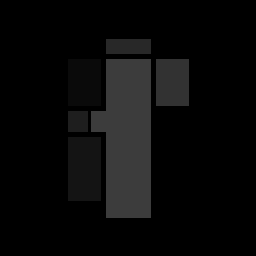

: 

In [ ]:
ind = 13047
line = f"../floorplan_dataset/{ind}.png"
base_img = np.asarray(Image.open(line))
img_room_ind = fix_contour_holes(base_img[:,:,2])
image_base = Image.fromarray(10*img_room_ind.astype(np.uint8))
display(image_base)
image_base.save("image_base.png")

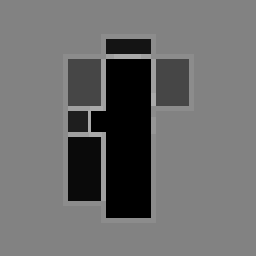

In [4]:
ind = 13047
line = f"../floorplan_dataset/{ind}.png"
base_img = np.asarray(Image.open(line))
img_room_ind = base_img[:,:,1]
image_base = Image.fromarray(10*img_room_ind.astype(np.uint8))
display(image_base)
image_base.save("image_base.png")

/tmp/ipykernel_4373/1739328955.py:227: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  min_bound = int(edge[left_ind][bound_ind])
/tmp/ipykernel_4373/1739328955.py:228: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_bound = int(edge[right_ind][bound_ind])
/tmp/ipykernel_4373/1739328955.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  polygon = [(int(p[1]), int(p[0])) for p in polygon]


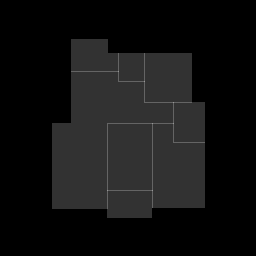

In [6]:
rooms = get_rooms_without_spans(base_img)
flat_mask = np.zeros((256, 256))
for room in rooms:
    flat_mask += room["mask"]
image = Image.fromarray(50*flat_mask.astype(np.uint8))
display(image)
image.save(f"image_test.png")

/tmp/ipykernel_4141/2168127290.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  polygon = [(int(p[1]), int(p[0])) for p in polygon]


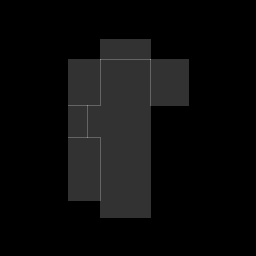

In [5]:
image_ind = 13047
json_path = "/home/evgmaslov/Files/rplan_json"
names = [name for name in os.listdir(json_path) if name.startswith(f"{image_ind}")]
if len(names) != 0:
    name = names[0]
    path = os.path.join(json_path, name)
    with open(path, "r") as f:
        json_dict = json.load(f)
    flat_mask = np.zeros((256, 256))
    rooms = []
    for polygon in [r["polygon"] for r in json_dict["rooms"]]:
        polygon = [np.expand_dims(np.array(v), axis=1) for v in np.array(polygon).T.tolist()]
        mask = polygon_to_mask(polygon)
        rooms.append(mask)
        flat_mask += mask
    flat_mask = flat_mask*50
    image = Image.fromarray(flat_mask.astype(np.uint8))
    display(image)
    image.save(f"image_test.png")

/tmp/ipykernel_53266/1901397484.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  polygon = [(int(p[1]), int(p[0])) for p in polygon]


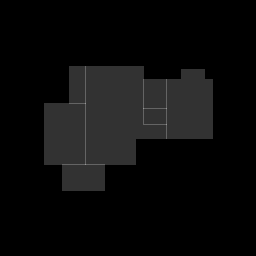

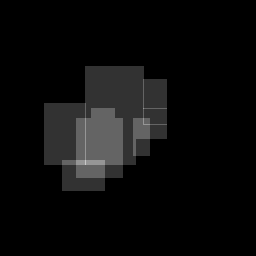

[[0, [1, 0]], [1, [6, 3]], [1, [5, 2]]]


In [4]:
eval_ind = 6
rplan_json_corrupt_path = "/home/evgmaslov/Files/rplan_json_corrupt"
names = os.listdir(rplan_json_corrupt_path)
eval_path = os.path.join(rplan_json_corrupt_path, names[eval_ind])
with open(eval_path, "r") as f:
    json_dict = json.load(f)
rooms = json_dict["rooms"]

polygons = [[np.expand_dims(np.array(v), axis=1) for v in np.array(room["polygon"]).T.tolist()] for room in rooms]
flat_mask = np.zeros((256, 256))
for p in polygons:
    mask = polygon_to_mask(p)
    flat_mask[*np.where(mask == 1)] += 1
flat_img = Image.fromarray(50*flat_mask.astype(np.uint8))
display(flat_img)

cor_polygons = [[np.expand_dims(np.array(v), axis=1) for v in np.array(room["cor_polygon"]).T.tolist()] for room in rooms]
cor_flat_mask = np.zeros((256, 256))
for p in cor_polygons:
    mask = polygon_to_mask(p)
    cor_flat_mask[*np.where(mask == 1)] += 1
cor_flat_img = Image.fromarray(50*cor_flat_mask.astype(np.uint8))
display(cor_flat_img)

print(json_dict["cor_sequence"])

In [4]:
! pwd

/media/evgmaslov/Expansion/Work/AIRI/computational_intelligence/house_diffusion/house_diffusion_refactored/sandbox


In [1]:
import argparse
from script_utils import add_dict_to_argparser
from diffusion_utils import diffusion_defaults, GaussianDiffusion
from model_utils import model_defaults, HouseTransformerModel, DiffusionModel, CorruptDiffusionModel
from train_utils import train_defaults, ImageCallback
from data_utils import get_rplan_dataset, get_corruption_dataset, corruption_collator
from transformers import Trainer, TrainingArguments

In [ ]:
dataset_json_folder = "/home/evgmaslov/Files/rplan_json_corrupt"
task_type = "corrupt_correction"
loss_type = "MSE"
test_size=0.1
random_seed=42

model = HouseTransformerModel(**model_defaults())
diffusion = GaussianDiffusion(**diffusion_defaults())
model.to("cuda")
diffusion_model = CorruptDiffusionModel(model, diffusion, loss_type)

dataset = get_rplan_dataset(dataset_json_folder, model.analog_bit) if task_type == "floorplan_generation" else get_corruption_dataset(dataset_json_folder)
dataset = dataset.train_test_split(test_size=test_size, seed=random_seed)

  0%|          | 0/78242 [00:00<?, ?it/s]

In [4]:
lr=1e-4
weight_decay=0.0
batch_size=1
n_epochs=1
output_dir="/media/evgmaslov/Expansion/Work/AIRI/computational_intelligence/house_diffusion/house_diffusion_refactored/checkpoints"
save_steps=100
eval_strategy="steps"
eval_steps=100
push_to_hub=False
hub_strategy="checkpoint"

training_params = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=n_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_steps=save_steps, 
    learning_rate=lr, weight_decay=weight_decay,
    fp16=False, bf16=False,
    report_to="wandb",
    save_total_limit=2,
    eval_strategy=eval_strategy,
    eval_steps=eval_steps,
    push_to_hub=push_to_hub,
    hub_strategy=hub_strategy,
    remove_unused_columns=False)
trainer = Trainer(
    model=diffusion_model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=corruption_collator,
    args=training_params)
if task_type == "corrupt_correction":
    wandb_callback = ImageCallback(trainer, dataset["test"], num_samples=2)
    trainer.add_callback(wandb_callback)
trainer.train()

  0%|          | 0/70417 [00:00<?, ?it/s]

TypeError: DiffusionModel.forward() got an unexpected keyword argument 'shift'